In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

target 별 특징을 생각해보던 중 Image 변환을 시도해 보았습니다. groupby 후 센서마다 mean 값(32개 센서)을 8 by 4 이미지로 변환해서 살펴봤습니다.

In [3]:
gr_mu = train.groupby('target').mean().iloc[:, 1 :]
gr_mu

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
target,,,,,,,,,,,,,,,,,,,,,
0,-0.425433,-0.922978,1.389976,0.559473,-0.694207,0.015784,0.793226,-0.913523,-0.561867,-0.802052,...,0.022476,-0.056393,-1.587852,-0.420015,0.905688,0.151944,-0.626062,-0.822711,-0.621473,-1.962038
1,-0.692796,-0.776260,-1.040046,-0.796645,-0.716867,-0.864049,0.217547,-0.588134,-0.795507,-0.470282,...,-0.727154,-0.841780,-0.605011,-0.622476,0.257340,-0.515845,-0.883002,-0.682358,0.154507,-0.607232
2,-2.346430,-0.822219,1.015480,0.079543,0.805130,-0.322211,-1.559588,-1.354339,-1.188115,-1.084991,...,0.926393,-0.561614,-0.598858,-0.591853,-2.619469,-0.660750,-0.706551,-0.714254,-0.997320,-0.504212
3,-0.983485,-1.559744,-3.951593,-0.422654,-0.727304,-0.518749,3.218229,-0.876624,-0.636275,-0.459929,...,-0.134662,0.026740,-0.935549,-0.714854,1.169092,-0.441372,-0.693405,-1.013212,-0.500214,0.046207


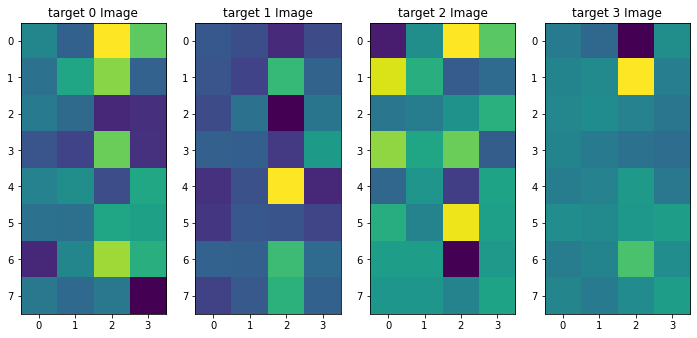

In [4]:
f, a = plt.subplots(1, 4, figsize = (12, 6))
for i in range(4) :
    a[i].set_title(f'target {i} Image')
    a[i].imshow(np.array(gr_mu.iloc[i]).reshape(8, 4))

비록 통계량을 통해 봤지만 target별로 어느 정도 다른 형태를 띈다고 볼 수 있을 것 같습니다.

In [5]:
X = train.iloc[:, 1:-1]
target = test.iloc[:, 1:]

sensor1 ~ 32이기 때문에 8 * 4형태로 바꾸어줍니다.

In [8]:
X = np.array(X).reshape(-1, 8, 4, 1)
target = np.array(target).reshape(-1, 8, 4, 1)

MultiClass를 위해 target 값에 One-Hot 인코딩을 취해줍니다.

In [6]:
ohe = OneHotEncoder(sparse = False)

In [7]:
y = ohe.fit_transform(train[['target']])

In [10]:
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

In [122]:
es = EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'max', verbose = 0)

In [139]:
cnn_acc = []
cnn_pred = np.zeros((target.shape[0], 4))
for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### CNN 모델
    cnn = Sequential()
    cnn.add(Conv2D(8, (2, 2), padding = "same", activation = 'elu', input_shape = (8, 4, 1)))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(16, (2, 2), padding = "same", activation = 'elu'))
    cnn.add(MaxPooling2D(2, 2))
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'elu'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'elu'))
    cnn.add(BatchNormalization())
    cnn.add(GlobalAveragePooling2D())
    cnn.add(Dense(16, activation = 'relu'))
    cnn.add(Dense(4, activation = 'softmax'))

    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'max', verbose = 0)
    
    ### 모델 compile
    cnn.compile(optimizer = RMSprop(learning_rate = 0.04), loss = 'categorical_crossentropy', metrics = ['acc'])

    cnn.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f'{i + 1} Fold ACC of CNN = {fold_cnn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(target) / skf.n_splits
    cnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of CNN = 0.8034188034188035
2 Fold Training.....
2 Fold ACC of CNN = 0.8205128205128205
3 Fold Training.....
3 Fold ACC of CNN = 0.8376068376068376
4 Fold Training.....
4 Fold ACC of CNN = 0.8760683760683761
5 Fold Training.....
5 Fold ACC of CNN = 0.8076923076923077
6 Fold Training.....
6 Fold ACC of CNN = 0.8197424892703863
7 Fold Training.....
7 Fold ACC of CNN = 0.8068669527896996
8 Fold Training.....
8 Fold ACC of CNN = 0.8197424892703863
9 Fold Training.....
9 Fold ACC of CNN = 0.8497854077253219
10 Fold Training.....
10 Fold ACC of CNN = 0.8412017167381974


In [140]:
np.mean(cnn_acc)

0.8282638201093135

In [144]:
submission['target'] = np.argmax(cnn_pred, axis = 1)

In [145]:
submission.to_csv('1st.csv', index = False)

In [146]:
submission.target.value_counts()

1    2471
2    2367
0    2272
3    2233
Name: target, dtype: int64